In [23]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#폰트 설정 (Windows 기본 폰트: 맑은 고딕)
plt.rcParams.update({
    "font.family": "Malgun Gothic",  # 윈도우 기본 한글 폰트
    "font.size": 10,
    "axes.unicode_minus": False,     # 마이너스 깨짐 방지
})

## 과제 1: SVD로 이미지 압축 해보기
자신의 이미지를 SVD로 압축하고 k값에 따른 변화 관찰


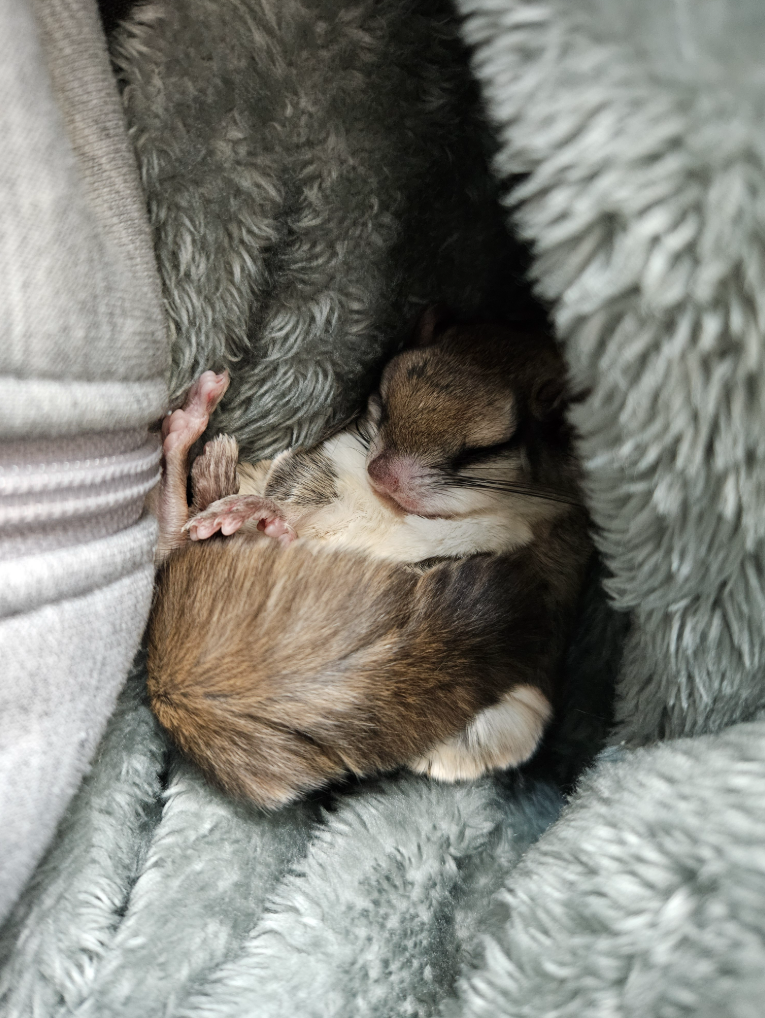

In [24]:
np.array(Image.open('lui.jpg'))

array([[[130, 139, 134],
        [125, 134, 129],
        [133, 142, 137],
        ...,
        [159, 168, 163],
        [171, 180, 175],
        [157, 166, 161]],

       [[102, 111, 106],
        [122, 131, 126],
        [132, 141, 136],
        ...,
        [158, 167, 162],
        [152, 161, 156],
        [154, 163, 158]],

       [[142, 151, 146],
        [137, 146, 141],
        [125, 134, 129],
        ...,
        [152, 161, 156],
        [146, 155, 150],
        [155, 164, 159]],

       ...,

       [[159, 158, 154],
        [166, 165, 161],
        [169, 168, 164],
        ...,
        [164, 170, 168],
        [150, 156, 154],
        [170, 176, 174]],

       [[160, 159, 155],
        [160, 159, 155],
        [158, 157, 153],
        ...,
        [175, 181, 179],
        [170, 176, 174],
        [175, 181, 179]],

       [[182, 181, 177],
        [181, 180, 176],
        [173, 172, 168],
        ...,
        [177, 183, 181],
        [169, 175, 173],
        [170, 176, 174]]

In [25]:
img = np.array(Image.open('lui.jpg').convert('L'))

print(f"원본 이미지 크기: {img.shape}")

원본 이미지 크기: (3000, 4000)


In [26]:
U, s, VT = np.linalg.svd(img, full_matrices=False)

In [27]:
s.shape

(3000,)

In [28]:
s

array([4.67048959e+05, 9.53348443e+04, 8.13407339e+04, ...,
       9.56881003e+00, 9.46637109e+00, 9.36298984e+00])

In [29]:
k_values = [5, 20, 50, 100]

IndexError: index 2 is out of bounds for axis 0 with size 2

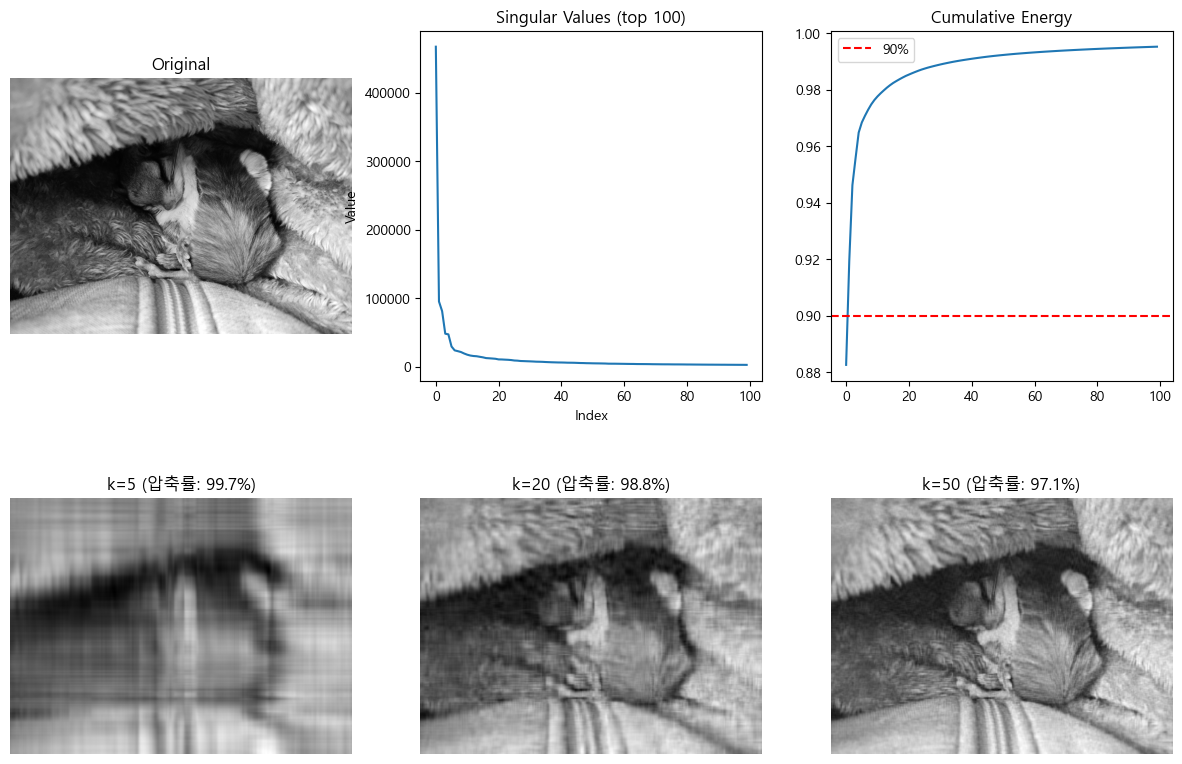

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(15,10))

# 원본
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

# 특잇값 그래프
axes[0, 1].plot(s[:100])
axes[0, 1].set_title('Singular Values (top 100)')
axes[0, 1].set_xlabel('Index')
axes[0, 1].set_ylabel('Value')

# 누적 에너지
cumsum = np.cumsum(s**2) / np.sum(s**2)
axes[0, 2].plot(cumsum[:100])
axes[0, 2].set_title('Cumulative Energy')
axes[0, 2].axhline(y=0.9, color='r', linestyle='--', label='90%')
axes[0, 2].legend()


# 압축된 이미지들
for idx, k in enumerate(k_values):
    # k개 특잇값으로 재구성
    img_compressed = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]
    
    # 압축률 계산
    original_size = img.shape[0] * img.shape[1]
    compressed_size = k * (img.shape[0] + img.shape[1] + 1)
    ratio = (1 - compressed_size / original_size) * 100
    
    # 시각화
    row = 1 + idx // 3
    col = idx % 3
    axes[row, col].imshow(img_compressed, cmap='gray')
    axes[row, col].set_title(f'k={k} (압축률: {ratio:.1f}%)')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 정보 보존률 계산
for k in k_values:
    energy = np.sum(s[:k]**2) / np.sum(s**2) * 100
    print(f"k={k}: 정보 보존률 {energy:.1f}%")

k=5: 정보 보존률 96.5%
k=20: 정보 보존률 98.5%
k=50: 정보 보존률 99.2%
k=100: 정보 보존률 99.5%


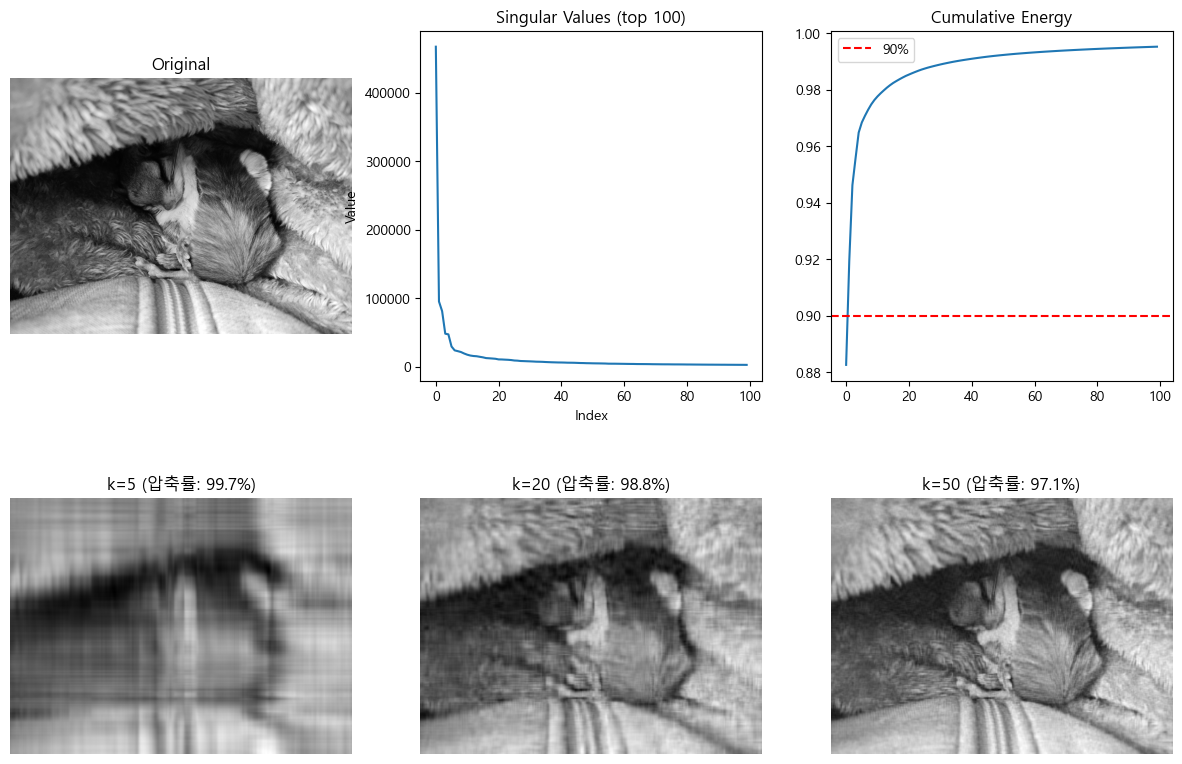

#### Singular Values
처음 몇개의 값이 크고, 나머지는 빠르게 작아지는걸로 보아 이미지의 대부분 벙보가 앞 쪽 몇개 특이값 안에 들어있다.


#### Cumulative Energy
빨간 점선(90%)이 목표선으로, 이미 20개 되기 전에 해당 선을 넘어선다.
즉 100개의 데이터 중 20개만 남겨도 원본과 거의 똑같은 품질이라는 뜻


K=5     흐릿하고 큰 윤곽만 남음

K=20    원본과 비슷하나 약간 디테일이 날아감

K=50    육안으로 원본과 거의 동일한 수준


## 과제 2: 파라미터 실험
eps와 min_samples 조정하기

→ 최적 선택 및 결과 비교

원본 X shape: (400, 2) | 표준화 Xs shape: (400, 2)


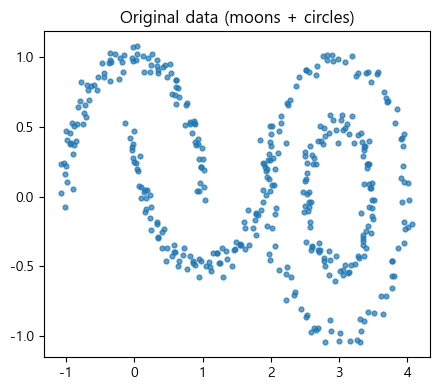

'\n합성 데이터는 축마다 분산이 다를 수 있음 → eps 의미가 왜곡된다.\n표준화로 각 축을 평균 0, 표준편차 1로 맞춰 공정한 거리를 만든다.\n'

In [39]:
# === 구역 1: 데이터 생성 & 스케일링 ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import StandardScaler

# 1) 복잡한 모양 데이터 생성
X1, _ = make_moons(n_samples=200, noise=0.05, random_state=0)
X2, _ = make_circles(n_samples=200, noise=0.05, factor=0.5, random_state=0)
X2[:, 0] += 3   # 원형 데이터를 오른쪽으로 이동 (두 덩어리 분리)
X = np.vstack([X1, X2])

# 2) 스케일링 (DBSCAN은 거리 스케일에 민감하다.)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

print("원본 X shape:", X.shape, "| 표준화 Xs shape:", Xs.shape)

# 원본 산점도 확인
plt.figure(figsize=(4.5,4))
plt.scatter(X[:,0], X[:,1], s=12, alpha=0.7)
plt.title("Original data (moons + circles)")
plt.tight_layout(); 
plt.show()

'''
합성 데이터는 축마다 분산이 다를 수 있음 → eps 의미가 왜곡된다.
표준화로 각 축을 평균 0, 표준편차 1로 맞춰 공정한 거리를 만든다.
'''


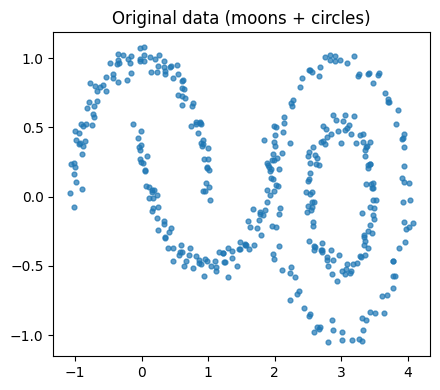


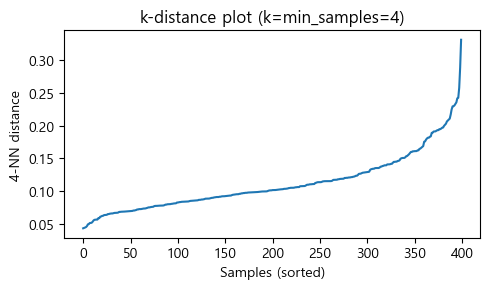

eps 탐색 범위: 0.1204 ~ 0.242
min_samples 후보: [4, 5, 8, 10, 20]


In [32]:
# === 구역 2: k-distance plot & eps 범위 추정 ===================
from sklearn.neighbors import NearestNeighbors

def k_distance_sorted(Xs, k):
    """
    Xs: 표준화된 데이터 (n, d)
    k : min_samples 후보 (자기 자신 제외 시 k번째 이웃거리 사용)
    반환: 오름차순 정렬된 k-distance 벡터
    """
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(Xs)
    dists, _ = nn.kneighbors(Xs)
    kth = np.sort(dists[:, -1])  # 각 점의 k번째 이웃까지 거리
    return kth

# min_samples 후보를 몇 개 정의
n = len(Xs)
min_samples_candidates = sorted(set([4, 5, 8, 10, int(np.sqrt(n))]))
min_samples_candidates = [m for m in min_samples_candidates if m >= 3]

m_for_elbow = min_samples_candidates[0]  # 대표값 하나로 elbow 확인
kth = k_distance_sorted(Xs, k=m_for_elbow)

plt.figure(figsize=(5,3))
plt.plot(kth)
plt.title(f'k-distance plot (k=min_samples={m_for_elbow})')
plt.xlabel('Samples (sorted)'); plt.ylabel(f'{m_for_elbow}-NN distance')
plt.tight_layout(); plt.show()

# 경험칙: 70~99 분위수에서 eps 후보를 스윕
lo, hi = np.percentile(kth, 70), np.percentile(kth, 99)
eps_grid = np.linspace(lo, hi, 12)

print("eps 탐색 범위:", round(lo,4), "~", round(hi,4))
print("min_samples 후보:", min_samples_candidates)


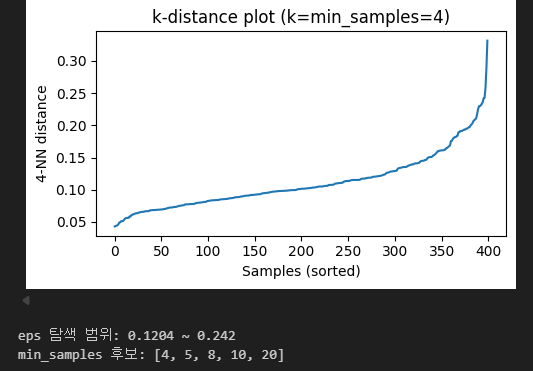

그래프가 완만하다가 0.25 부근에서 급상승하는 팔꿈치 형태

팔꿈치 이전(0.12~0.18): 너무 작은 eps → 군집이 과도하게 쪼개짐.

팔꿈치 이후(>0.25): 너무 큰 eps → 서로 다른 군집이 합쳐짐.

따라서 eps는 0.12~0.24 구간이 합리적

In [33]:
# === 구역 3: 그리드 탐색 & 결과표 =============================
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

def evaluate_dbscan(Xs, eps, min_samples):
    labels = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit_predict(Xs)
    n_noise = np.sum(labels == -1)
    n_clusters = len(set(labels) - {-1})
    noise_ratio = n_noise / len(labels)
    sil = np.nan
    if n_clusters >= 2 and n_noise < len(labels):
        mask = labels != -1
        if mask.sum() > n_clusters:  # 실루엣 계산 안전장치
            sil = silhouette_score(Xs[mask], labels[mask])
    return n_clusters, noise_ratio, sil, labels

rows = []
for m in min_samples_candidates:
    for eps in eps_grid:
        n_clusters, noise_ratio, sil, _ = evaluate_dbscan(Xs, eps, m)
        rows.append({
            'eps': round(float(eps), 4),
            'min_samples': int(m),
            'n_clusters': int(n_clusters),
            'noise_ratio': round(float(noise_ratio), 4),
            'silhouette': (np.nan if np.isnan(sil) else round(float(sil), 4))
        })

result = pd.DataFrame(rows).sort_values(
    ['silhouette','n_clusters'], ascending=[False, False]
)

print("=== 상위 10개 조합(실루엣 기준) ===")
print(result.head(10).to_string(index=False))

'''
실루엣↑: 군집 간 분리가 잘 됨.
노이즈 비율↓: 해석하기 쉬움.
군집 수는 너무 작아도(1) 안 되고, 너무 많아도 과분할.
'''


=== 상위 10개 조합(실루엣 기준) ===
   eps  min_samples  n_clusters  noise_ratio  silhouette
0.1315           10           2       0.9500      0.9089
0.1204            8           7       0.8325      0.8458
0.1536           10           5       0.7450      0.7841
0.1425           10           6       0.8250      0.6779
0.1646           10           8       0.6100      0.6260
0.1425            8          13       0.5625      0.6040
0.1757           10          11       0.5275      0.5990
0.1867           10          10       0.4825      0.5890
0.1315            8          11       0.6700      0.5847
0.1536            8          14       0.4525      0.5129


'\n실루엣↑: 군집 간 분리가 잘 됨.\n노이즈 비율↓: 해석하기 쉬움.\n군집 수는 너무 작아도(1) 안 되고, 너무 많아도 과분할.\n'

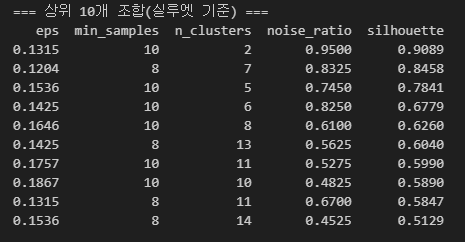

실루엣 0.90이 가장 높지만, 군집이 2개이고 노이즈가 95%다.


=== 추천 파라미터 ===
{'eps': 0.1315, 'min_samples': 10}
최종 군집 수: 2, 노이즈 비율: 0.950


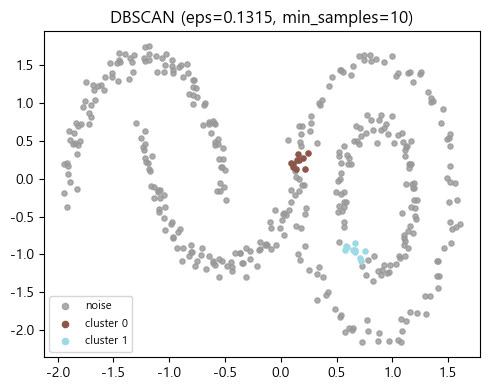

In [34]:
# === 구역 4: 추천 파라미터 선택 & 시각화 ======================
best_params = None
valid = result[(result.n_clusters >= 2) & result.silhouette.notna()].copy()
if not valid.empty:
    target_k = 5 if valid.n_clusters.max() >= 5 else 2
    valid['k_penalty'] = (valid.n_clusters - target_k).abs()
    best = valid.sort_values(
        ['silhouette','noise_ratio','k_penalty'],
        ascending=[False, True, True]
    ).iloc[0]
    best_params = {'eps': float(best.eps), 'min_samples': int(best.min_samples)}
    print("\n=== 추천 파라미터 ===")
    print(best_params)
else:
    print("\n유효한 군집(>=2)을 찾지 못함 → eps↑ 또는 min_samples↓로 범위 재설정 권장.")

# 시각화
if best_params is not None:
    _, _, _, labels = evaluate_dbscan(Xs, **best_params)
    n_clusters = len(set(labels) - {-1})
    noise_ratio = np.mean(labels == -1)
    print(f"최종 군집 수: {n_clusters}, 노이즈 비율: {noise_ratio:.3f}")

    plt.figure(figsize=(5,4))
    unique = sorted(set(labels))
    palette = plt.cm.tab20(np.linspace(0,1,len(unique)))
    color_map = {lab: col for lab, col in zip(unique, palette)}
    color_map[-1] = (0.6,0.6,0.6,0.8)  # noise=grey

    for lab in unique:
        m = labels == lab
        plt.scatter(Xs[m,0], Xs[m,1], s=14,
                    c=[color_map[lab]],
                    label=('noise' if lab==-1 else f'cluster {lab}'))
    plt.title(f"DBSCAN (eps={best_params['eps']}, min_samples={best_params['min_samples']})")
    plt.legend(markerscale=1.2, fontsize=8)
    plt.tight_layout(); plt.show()


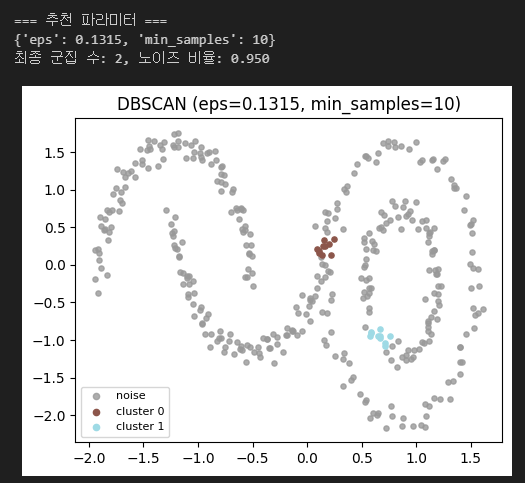

eps : 0.1315
min_samples : 10
최종 군집 수 : 2
노이즈 비율 : 0.95 (그림에서 보이는 회색)

너무 보수적으로 잡혀 핵심점으로 인정받는 데이터가 거의 없다.
eps가 너무 작고 min_samples가 많아 밀도가 높은 구간만 군집으로 인식한다.

eps를 살짝 늘리거나 min_samples를 낮춰보기.

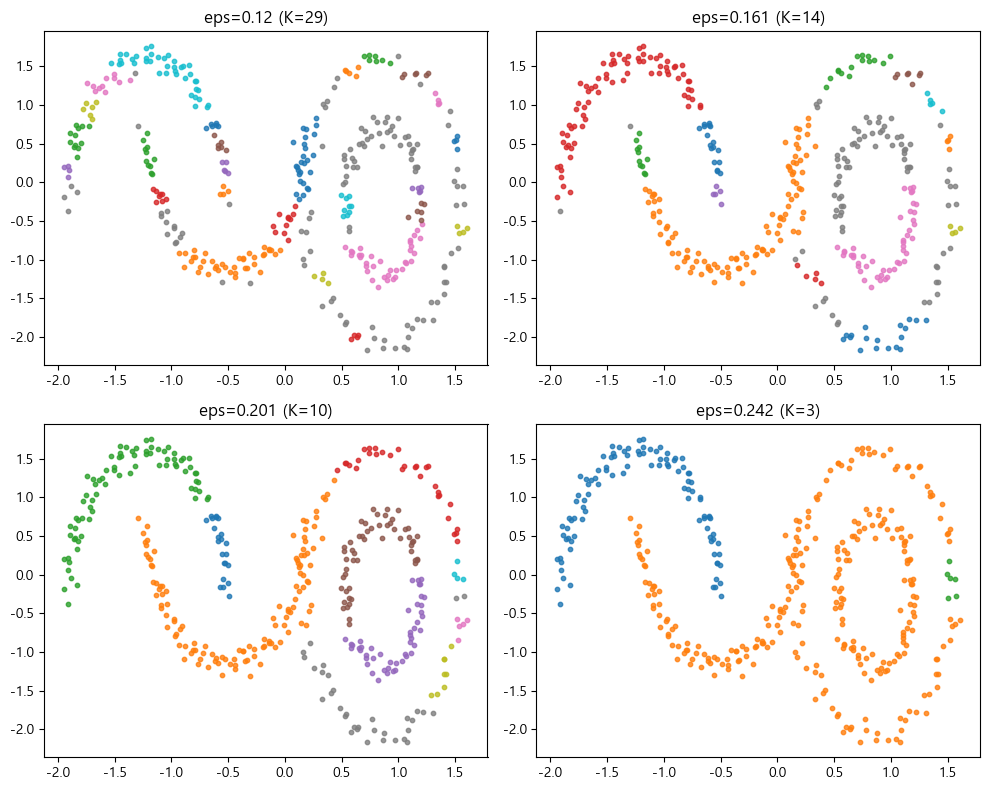

In [35]:
# === 구역 5: eps 여러 값 비교 패널 =====================
eps_values = [float(f) for f in np.linspace(eps_grid[0], eps_grid[-1], 4)]
fig, axes = plt.subplots(2, 2, figsize=(10,8))
for idx, eps in enumerate(eps_values):
    labels = DBSCAN(eps=eps, min_samples=min_samples_candidates[0]).fit_predict(Xs)
    n_clusters = len(set(labels) - {-1})

    ax = axes[idx//2, idx%2]
    unique = sorted(set(labels))
    for lab in unique:
        m = labels == lab
        c = 'gray' if lab==-1 else None
        ax.scatter(Xs[m,0], Xs[m,1], s=10, alpha=0.8, c=c)
    ax.set_title(f'eps={round(eps,3)} (K={n_clusters})')
plt.tight_layout(); plt.show()


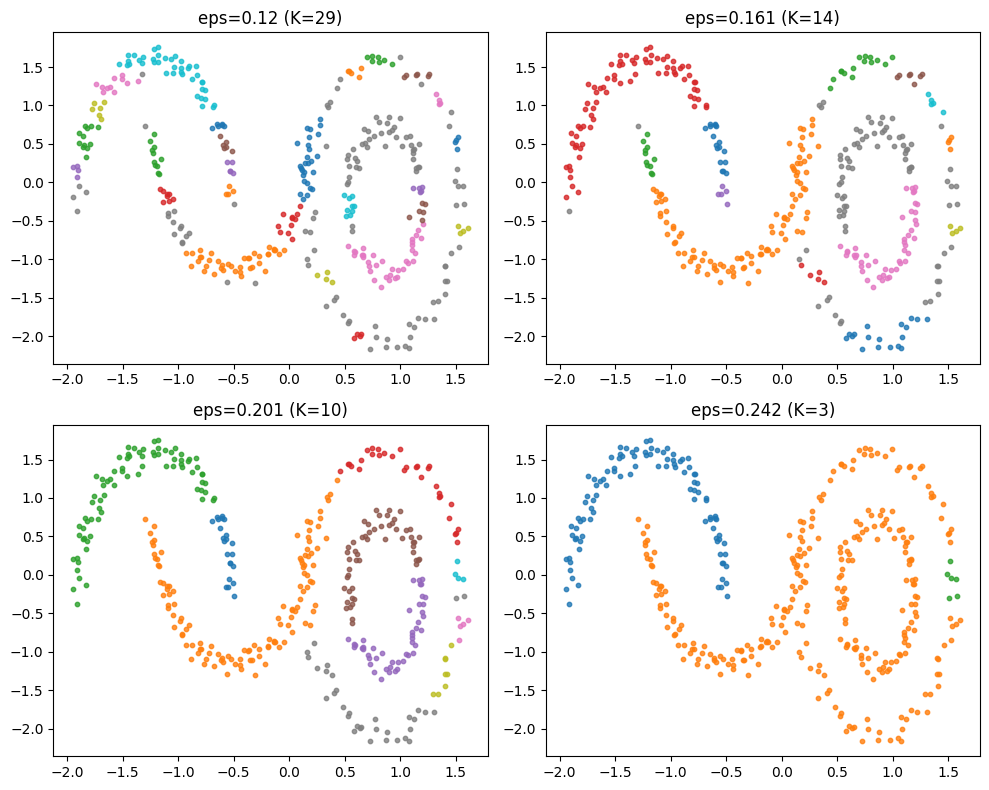

원래 테스트 : eps 0.1315

eps 0.12 : (29) 지나친 분할로 너무 세밀하며, 노이즈가 과다하다. 

eps 0.16 : (14) 군집이 늘어나며 0.13보다는 노이즈가 줄어든다.

eps 0.20 : (10) 0.16보다 곡선이 더 자연스럽게 군집화 됬다. 

eps 0.24 : (3) 곡선이 합쳐지며 마치 군집이 뭉친 것 처럼 보인다.


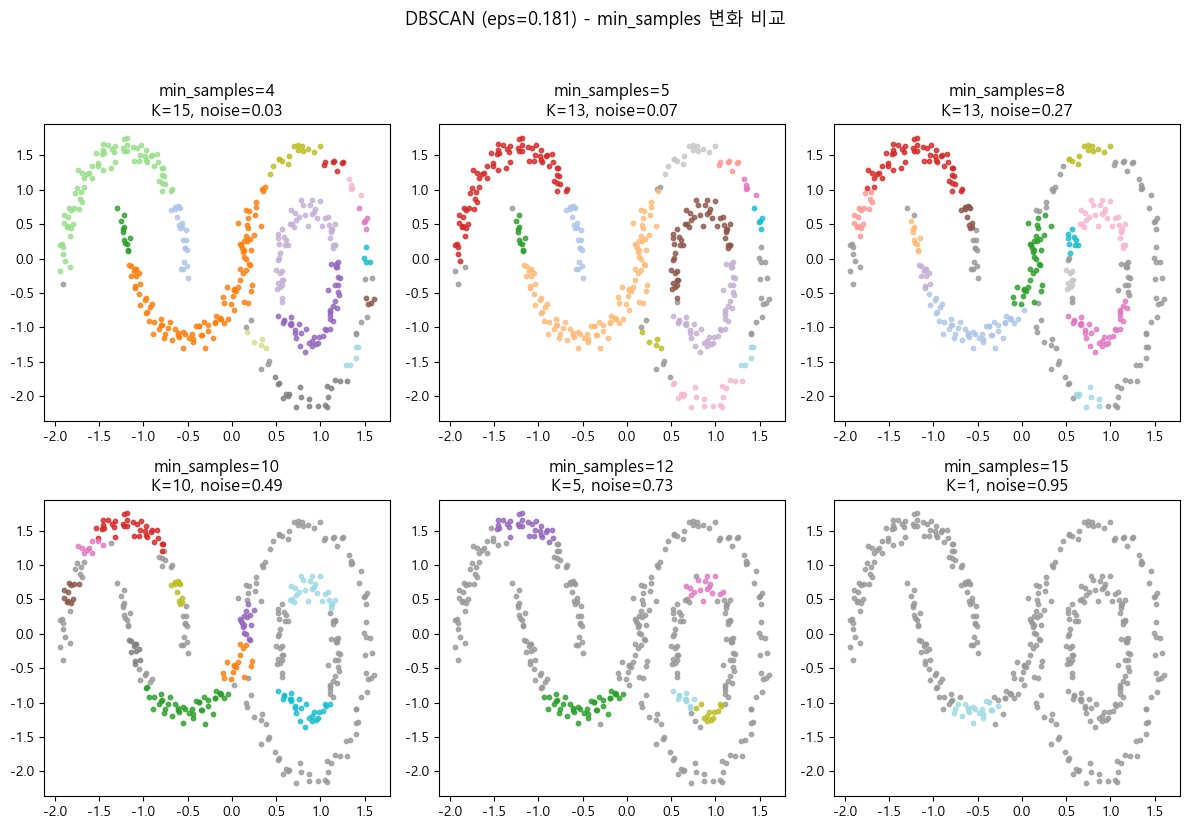

In [36]:
# === 구역 6: min_samples 여러 값 비교 패널 =====================
# eps는 위 실험의 추천값이나 중앙값 사용 (eps_base로 명시)
eps_base = float(np.median(eps_grid)) if 'eps_grid' in locals() else 0.18

# 4, 5, 8, 10, 12, 15 등 다양한 군집 기준을 비교
min_samples_list = [4, 5, 8, 10, 12, 15]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for idx, m in enumerate(min_samples_list):
    db = DBSCAN(eps=eps_base, min_samples=m)
    labels = db.fit_predict(Xs)
    n_clusters = len(set(labels) - {-1})
    n_noise = np.sum(labels == -1)
    noise_ratio = n_noise / len(labels)

    ax = axes[idx]
    unique = sorted(set(labels))
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique)))
    color_map = {lab: col for lab, col in zip(unique, colors)}
    color_map[-1] = (0.6, 0.6, 0.6, 0.8)  # 회색 = 노이즈(-1) 포인트로, 군집으로 포함되지 않은 데이터

    for lab in unique:
        mask = labels == lab
        ax.scatter(Xs[mask, 0], Xs[mask, 1], s=10, c=[color_map[lab]], alpha=0.8)
    # 각 그래프 상단에 “min_samples, 군집 수(K), 노이즈 비율” 자동 표시
    ax.set_title(f"min_samples={m}\nK={n_clusters}, noise={noise_ratio:.2f}")

# 빈 subplot은 끄기 (후보 개수가 6 미만일 때 대비)
for ax in axes[len(min_samples_list):]:
    ax.axis('off')

plt.suptitle(f"DBSCAN (eps={eps_base:.3f}) - min_samples 변화 비교", y=1.03, fontsize=13)
plt.tight_layout()
plt.show()


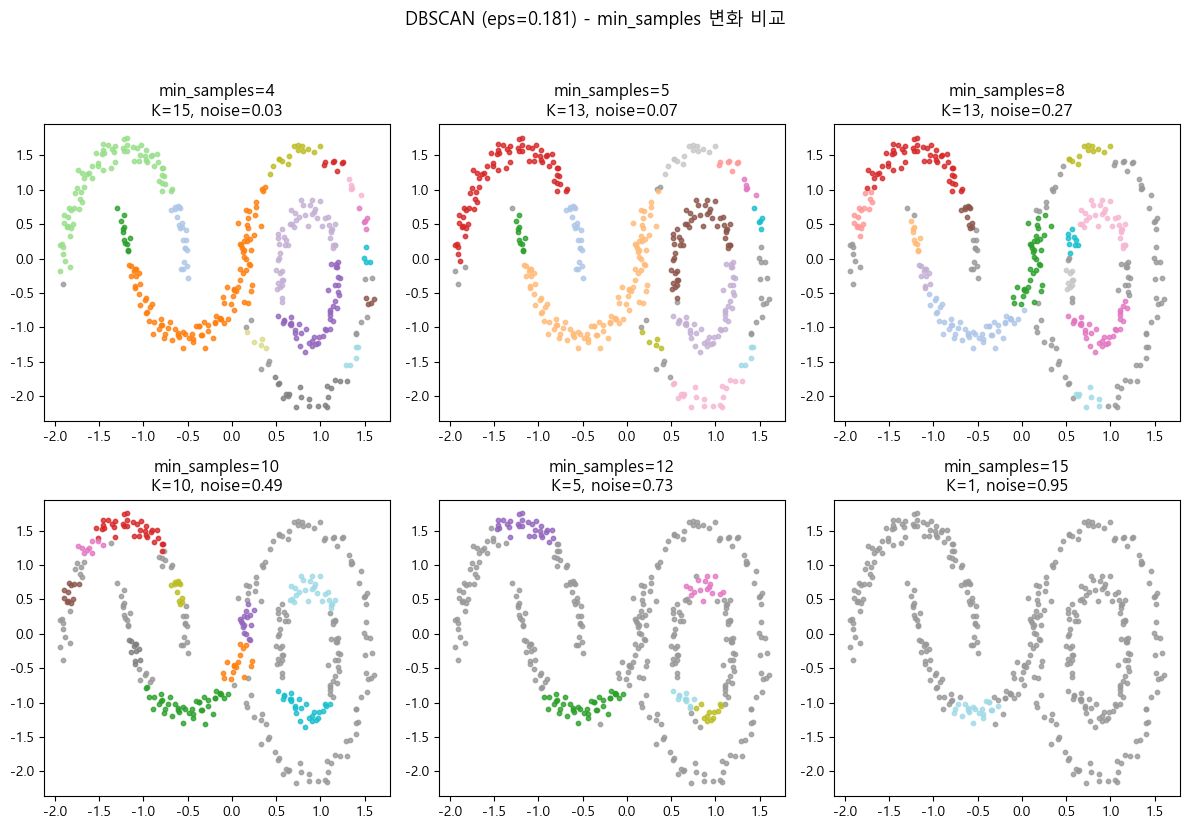

min_samples가 작을수록 군집이 세밀하게 쪼개지고 노이즈가 적다.(과분할)
min_samples가 클수록 군집이 통합되거나 노이즈가 많다.(과보수)

일반적으로 중간값에서 가장 구조가 자연스럽게 나온다.

=== eps × min_samples 결과 상위 10개 (실루엣 기준) ===
  eps  min_samples  K  noise_ratio  silhouette
0.218           15  3        0.780       0.862
0.120            8  7        0.833       0.846
0.193           12  5        0.655       0.764
0.242           15  5        0.593       0.730
0.169           12  4        0.818       0.694
0.145           10  7        0.797       0.634
0.218           12  6        0.542       0.628
0.169           10  9        0.573       0.627
0.193           15  3        0.870       0.595
0.193           10 10        0.443       0.570


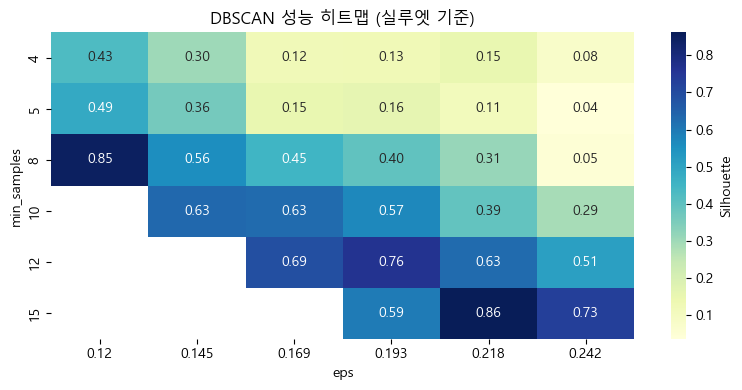

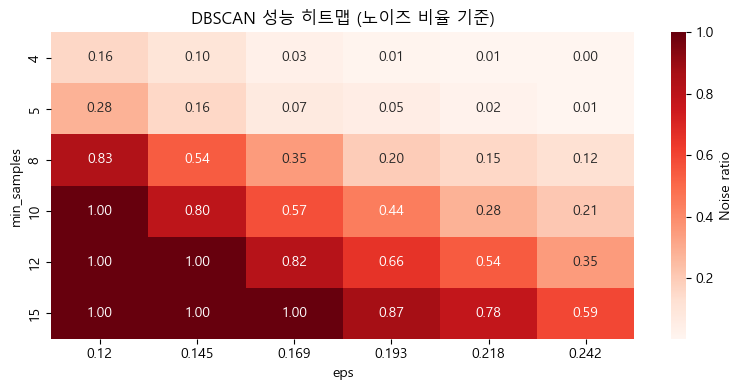

In [40]:
# === 구역 7: eps × min_samples 매트릭스 히트맵 =======================
import seaborn as sns
from sklearn.metrics import silhouette_score

# eps 후보 (기존 eps_grid 기반 or 0.12~0.24 범위)
eps_list = np.round(np.linspace(eps_grid[0], eps_grid[-1], 6), 3) if 'eps_grid' in locals() else np.linspace(0.12, 0.24, 6)
min_samples_list = [4, 5, 8, 10, 12, 15]

# 결과 저장 리스트
records = []

for eps in eps_list:
    for m in min_samples_list:
        labels = DBSCAN(eps=eps, min_samples=m).fit_predict(Xs)
        n_clusters = len(set(labels) - {-1})
        n_noise = np.sum(labels == -1)
        noise_ratio = n_noise / len(labels)

        # 실루엣 점수는 군집이 2개 이상일 때만 계산
        sil = np.nan
        if n_clusters >= 2 and n_noise < len(labels):
            mask = labels != -1
            if mask.sum() > n_clusters:
                sil = silhouette_score(Xs[mask], labels[mask])

        records.append({
            "eps": round(float(eps), 3),
            "min_samples": int(m),
            "K": n_clusters,
            "noise_ratio": round(float(noise_ratio), 3),
            "silhouette": np.nan if np.isnan(sil) else round(float(sil), 3)
        })

# 데이터프레임으로 변환
df_grid = pd.DataFrame(records)
print("=== eps × min_samples 결과 상위 10개 (실루엣 기준) ===")
print(df_grid.dropna().sort_values(['silhouette','K'], ascending=[False, False]).head(10).to_string(index=False))

# === 히트맵 시각화 (실루엣 기준) ===
pivot_sil = df_grid.pivot(index='min_samples', columns='eps', values='silhouette')

plt.figure(figsize=(8, 4))
sns.heatmap(pivot_sil, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Silhouette'})
plt.title("DBSCAN 성능 히트맵 (실루엣 기준)")
plt.ylabel("min_samples")
plt.xlabel("eps")
plt.tight_layout()
plt.show()

# === 히트맵 시각화 (노이즈 비율 기준) ===
pivot_noise = df_grid.pivot(index='min_samples', columns='eps', values='noise_ratio')

plt.figure(figsize=(8, 4))
sns.heatmap(pivot_noise, annot=True, cmap='Reds', fmt=".2f", cbar_kws={'label': 'Noise ratio'})
plt.title("DBSCAN 성능 히트맵 (노이즈 비율 기준)")
plt.ylabel("min_samples")
plt.xlabel("eps")
plt.tight_layout()
plt.show()


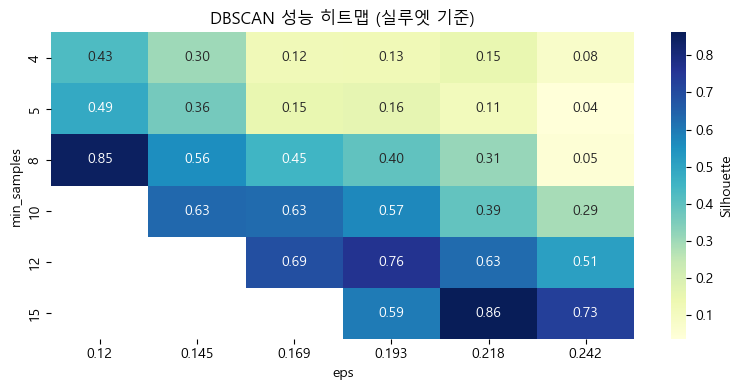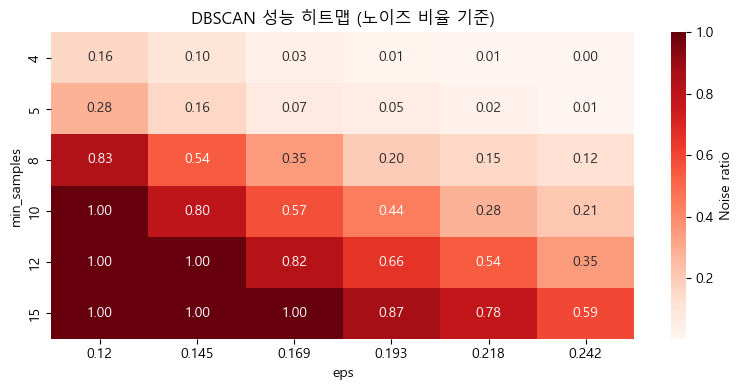

x축 : eps(이웃 반경) : 오른쪽(↑)으로 갈수록 반경이 넓어짐 -> 군집이 서로 붙기 시작 -> 노이즈가 줄고 군집 수가 감소

y츅 : min_samples(핵심점 기준) : 아래(↑)로 갈수록 기준이 빡세짐 -> 핵심점이 줄고 -> 노이즈가 증가


eps ↑ → 군집이 합쳐지고 노이즈 ↓
min_samples ↑ → 군집이 엄격해지고 노이즈 ↑


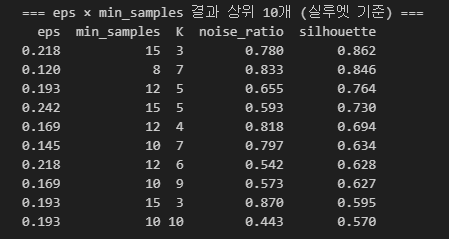

이웃반경 / 핵심점 기준 / 군집 수 / 노이즈비율 / 실루엣

이론상 최고 점수 : eps=0.218, min_samples=15 -> 군집 품질은 최고지만, 노이즈가 너무 많음. 즉, 너무 보수적(너무 빡세게 필터링).

밸런스 : eps=0.218, min_samples=12 -> 노이즈가 절반 수준, 실루엣도 양호.

덜 보수적 / 과분할 경향 : eps=0.193, min_samples=10 -> 노이즈는 적지만 군집이 너무 많아(10개). 과분할 상태.


DBSCAN의 sweet spot은 eps ≈ 0.20~0.22, min_samples ≈ 10~12.
이 구간은 실루엣과 노이즈 비율 간의 균형이 가장 이상적이다